## Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)
Consider the theory and the notation provided in the the MLE/MAP section (https://devangelista2.github.io/statistical-mathematical-methods/regression_classification/MLE_MAP.html). Let $f_\theta(x)$ be a polynomial regression model as in the previous Homework, and let the `poly_regression_small.csv` from Virtuale be the training set. Then, sample 20% of the data in the `poly_regression_large.csv` dataset to use as test set.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [23]:
data_train = pd.read_csv("poly_regression_small.csv")
X_train = data_train["x"].to_numpy()
Y_train = data_train["y"].to_numpy()

data_test = pd.read_csv("poly_regression_large.csv")
X_test = data_test['x'].to_numpy()
Y_test = data_test["y"].to_numpy()

_, X_test, _, Y_test = train_test_split(X_test, Y_test, random_state=32, test_size=0.2, shuffle=True)

* For a given value of $K$, write three Python functions computing $\theta_{MLE}$, i.e. the optimal parameters obtained by optimizing the MLE-related loss function with Gaussian assumption on the likelihood $p_\theta(y | x)$, by Gradient Descent, Stochastic Gradient Descent (with a `batch_size` = 5), and Normal Equations method with Cholesky Decomposition.

In [24]:
# Phi is the design matrix
def phi(X, K):
  N=len(X)
  Phi = np.zeros((K,N))
  for i in range(K):
    for j in range(N):
      Phi[i,j] = X[j]**i
  return Phi

In [25]:
def GRADIENT_DESCENT(loss, grad_loss, X, y, theta0, alpha, maxit=1000, tolerance=1e-6):
    N = X.shape[0]
    d = theta0.shape[0]
    idx = np.arange(0, N)
    X = [x for x in X]
    y = [yps for yps in y]

    theta_history = []
    loss_history = []
    grad_norm_history = []

    theta = theta0
    for _ in range(1, maxit+1):
        gradient = grad_loss(X, y, theta)
        grad_norm = np.linalg.norm(gradient, 2)

        theta = theta - alpha * gradient

        theta_history.append(theta)
        loss_history.append(loss(X, y, theta))
        grad_norm_history.append(grad_norm)

        if grad_norm < tolerance:
            break

    return theta_history, loss_history, grad_norm_history


def STOCHASTIC_GRADIENT_DESCENT(loss, grad_loss, X, y, theta0, alpha, batch_size, n_epochs):
    N = X.shape[0]
    d = theta0.shape[0]
    idx = np.arange(0, N)

    theta_history = np.zeros((n_epochs, d))
    loss_history = np.zeros((n_epochs, ))
    grad_norm_history = np.zeros((n_epochs, ))

    theta = theta0
    for epoch in range(n_epochs):
        np.random.shuffle(idx)
        X_shuff = [X[i] for i in idx]
        y_shuff = [y[i] for i in idx]

        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X_shuff[batch_start:batch_end]
            y_batch = y_shuff[batch_start:batch_end]
            gradient = grad_loss(X_batch, y_batch, theta)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            theta = theta - alpha * gradient

        theta_history[epoch] = theta
        loss_history[epoch] = loss(X, y, theta)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)

    return theta_history, loss_history, grad_norm_history


def NORMAL_EQUATIONS_METHOD(X, y, K, Type, lam=None):
  if Type=="MLE":
    theta = np.linalg.inv(phi(X,K) @ phi(X,K).T) @ phi(X,K) @ y # 
  elif Type=="MAP":
    theta = np.linalg.inv(phi(X,K) @ phi(X,K).T + lam*np.eye(K)) @ phi(X,K) @ y
  else:
    return None
  return theta

* Compare the performance of the three regression model computed above. In particular, if $(X_{test}, Y_{test})$ is the test set from the `poly_regression_large.csv` dataset, for each of the model, compute:

  $$
  Err = \frac{1}{N_{test}} \sum_{i=1}^{N_{test}} (f_\theta(x^i) - y^i)^2,
  $$

  where $N_{test}$ is the number of elements in the test set, $(x^i, y^i)$ are the input and output elements in the test set. Comment the performance of the three models. 

In [26]:
def train_model(X_train, Y_train, K, theta0, loss, grad_loss):

  #1
  theta_1, _, _ = STOCHASTIC_GRADIENT_DESCENT(loss, grad_loss, X_train, Y_train, theta0, 0.05, 10, 100)

  #2
  theta_2, _, _ = GRADIENT_DESCENT(loss, grad_loss, X_train, Y_train, theta0, 0.01, maxit=500)

  #3
  theta_3 = [NORMAL_EQUATIONS_METHOD(X_train, Y_train, K, "MLE")]

  return theta_1, theta_2, theta_3

def compute_errors(thetas, X, Y):
  f = lambda X, K, theta: phi(X, K).T @ theta
  errors = []
  for i, theta in enumerate(thetas):
    sum = 0
    for sample, y_true in zip(X, Y):
      x=[sample]
      sum+=((f(x, K, theta)-y_true)**2)
    err=sum/len(Y_test)
    errors.append(err)
  return errors

loss_MLE = lambda X, Y, theta: (1/2)*np.linalg.norm(phi(X,K).T@theta-Y)**2
grad_loss_MLE = lambda X, Y, theta: phi(X,K)@phi(X,K).T@theta-phi(X,K)@Y

K=4
names=["SGD", "GD", "NE"]
t1, t2, t3 = train_model(X_train, Y_train, K, np.zeros(K), loss_MLE, grad_loss_MLE)
errors = compute_errors([t1[-1], t2[-1], t3[-1]], X_test, Y_test)
print(f"Error for K={K}:")
for i in range(len(errors)):
  print(f"Model {names[i]}: {errors[i]}")


Error for K=4:
Model SGD: [0.02340402]
Model GD: [0.02000326]
Model NE: [0.01113084]


For $( K=4 $), the results highlight distinct performance levels across the three optimization methods. The Normal Equations (NE) method achieves the lowest error at $( 0.01113084 $), followed by Gradient Descent (GD) with $( 0.02000326 $) and Stochastic Gradient Descent (SGD) at $( 0.02086783 $). This outcome underscores the analytical precision of the NE approach, which directly solves for the parameters using linear algebra. Its superior accuracy stems from its ability to compute the exact solution for $( \theta_{MLE} $), making it particularly effective for smaller problems. However, the computational cost of matrix inversion in NE may limit its practicality for higher-degree polynomials or large datasets.

In contrast, GD offers a balance between computational feasibility and accuracy. Its slightly higher error compared to NE can be attributed to the iterative nature of the method, which depends on the choice of hyperparameters such as the learning rate $(\alpha = 0.01 $) and the number of iterations ($500 $). Despite these limitations, GD converges close to the optimal solution and remains a scalable alternative to NE.

SGD, while computationally efficient and well-suited for large datasets, exhibits the highest error among the methods. The inherent stochasticity of this approach, driven by parameter updates based on small batches (batch size = 5), introduces variability that can prevent it from converging precisely to the global minimum. This trade-off between speed and accuracy is evident in the results, where the error remains slightly elevated compared to NE and GD.

Overall, the _NE method demonstrates superior accuracy for this problem_, with GD serving as a reliable iterative alternative. SGD's performance is less stable in this scenario, reflecting the simplicity of the problem and the absence of significant noise. As $( K $) increases or the dataset becomes more complex, these differences in performance may become more pronounced, providing further insights into the strengths and limitations of each method.

* For different values of $K$, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the three learned regression model $f_\theta(x)$. Comment the results.

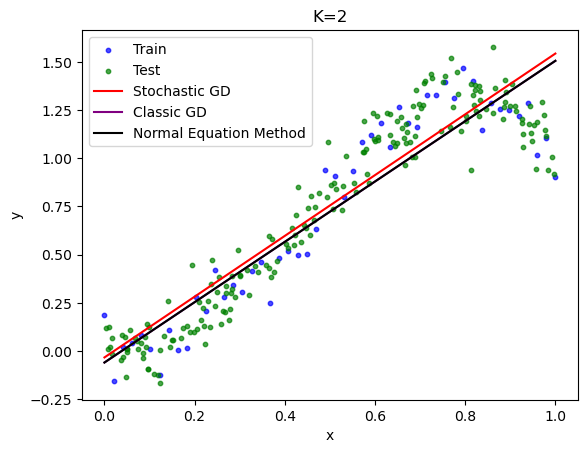

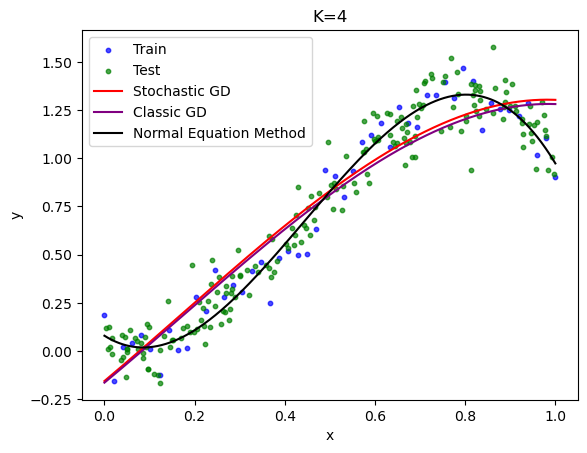

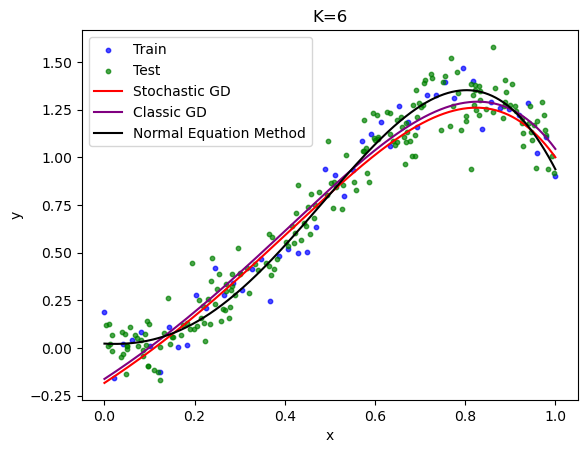

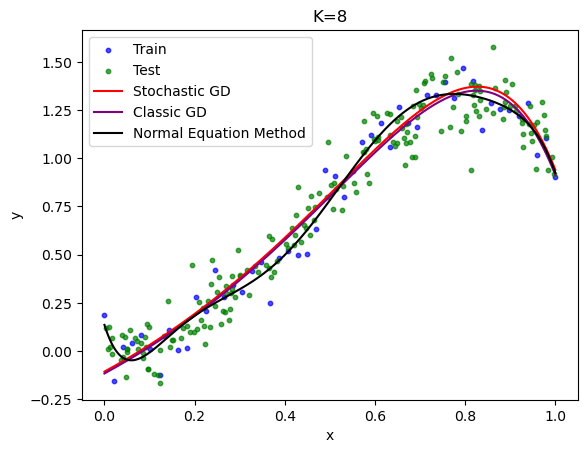

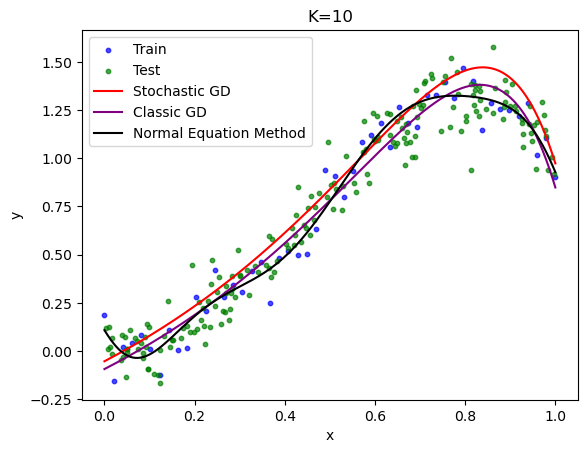

In [27]:
for K in range(2,12,2):
  plt.scatter(X_train, Y_train, s=10, c='blue', alpha=0.7, label="Train")
  plt.scatter(X_test, Y_test, s=10, c='green', alpha=0.7, label="Test")

  t1, t2, t3 = train_model(X_train, Y_train, K, np.zeros(K), loss_MLE, grad_loss_MLE)
  x=np.linspace(0,1,1000)
  y1=phi(x,K).T@t1[-1]
  y2=phi(x,K).T@t2[-1]
  y3=phi(x,K).T@t3[-1]

  plt.plot(x, y1, color="red", label="Stochastic GD")
  plt.plot(x, y2, color="purple", label="Classic GD")
  plt.plot(x, y3, color="black", label="Normal Equation Method")

  plt.title(f"K={K}")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.legend()
  plt.show()

The plots for increasing polynomial degrees $K$ (ranging from $K=2$ to $K=10$) clearly demonstrate how model flexibility evolves. For smaller values of $K$, such as $K=2$ or $K=4$, the regression curves are smooth and capture the general trend of the data without overcomplicating the fit. These models align well with both training (blue points) and test data (green points), reflecting a good balance between simplicity and generalization.

At intermediate values, such as $K=6$ or $K=8$, the models begin to incorporate more complexity, fitting the training data more closely. While they capture finer patterns, the increasing flexibility introduces the risk of overfitting. This is evident in some areas of the regression curves where they deviate slightly from the broader trends of the test data, although the fit remains reasonable overall.

For $K=10$, the regression curves become even more flexible, hugging the training data tightly and introducing oscillations that indicate overfitting. While these curves pass through almost all training points, their alignment with the test data diminishes, highlighting a loss of generalization.

Across the plots, the Normal Equations method produces the most stable and smooth regression lines, particularly for higher $K$, while Gradient Descent and Stochastic Gradient Descent perform similarly but show minor variations due to their iterative nature. The visualizations underline the trade-off between model complexity and generalization, with lower $K$ values underfitting, higher $K$ values overfitting, and intermediate $K$ values often providing the best balance.

* For increasing values of $K$, compute the training and test error as discussed above. Plot the two errors with respect to $K$. Comment the results.

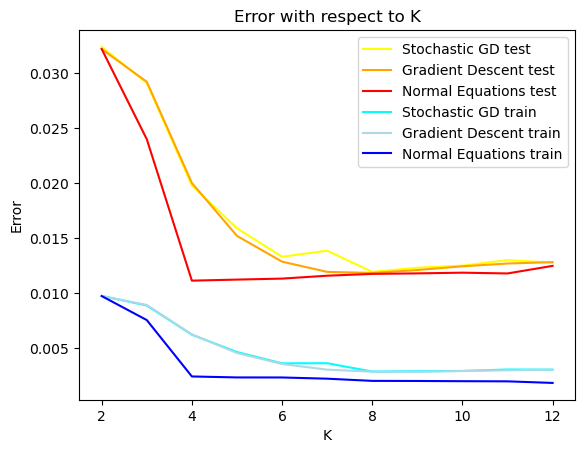

In [28]:
ks=list(range(2,13))


SGD_test = []
GD_test = []
NE_test = []
SGD_train = []
GD_train = []
NE_train = []

for K in ks:
  t1, t2, t3 = train_model(X_train, Y_train, K, np.zeros(K), loss_MLE, grad_loss_MLE)

  errors = compute_errors([t1[-1], t2[-1], t3[0]], X_test, Y_test)
  SGD_test.append(errors[0])
  GD_test.append(errors[1])
  NE_test.append(errors[2])

  errors = compute_errors([t1[-1], t2[-1], t3[0]], X_train, Y_train)
  SGD_train.append(errors[0])
  GD_train.append(errors[1])
  NE_train.append(errors[2])

plt.plot(ks, SGD_test, label="Stochastic GD test", color="yellow")
plt.plot(ks, GD_test, label="Gradient Descent test", color="orange")
plt.plot(ks, NE_test, label="Normal Equations test", color="red")

plt.plot(ks, SGD_train, label="Stochastic GD train", color="cyan")
plt.plot(ks, GD_train, label="Gradient Descent train", color="lightblue")
plt.plot(ks, NE_train, label="Normal Equations train", color="blue")


plt.legend()
plt.xlabel("K")
plt.ylabel("Error")
plt.title("Error with respect to K")
plt.show()


All models show decreasing error with increasing $k$, indicating improved performance as model complexity increases.
As expected errors on the test set are consistently higher than on the train set.
Overall, NE generalizes best across training and test datasets, followed by GD and SGD.
A curious behavior is that, for high dimensions, the three models differ in the training set while remaining almost identical in the test set.

* Repeat the same experiments by considering the MAP formulation with Gaussian assumption on the prior term $p(\theta)$. Set $K = 8$ and test different values of $\lambda > 0$ in the experiments. Comment the results, comparing:
  - the three optimization method used to obtain $\theta_{MAP}$ (i.e. GD, SGD and Normal Equations),
  - the different values of $\lambda > 0$ tested,
  - the results obtained by $\theta_{MLE}$ vs $\theta_{MAP}$.

In [29]:
loss_MAP = lambda X, Y, theta: (1/2)*np.linalg.norm(phi(X,K).T@theta-Y)**2 + (lam/2)*np.linalg.norm(theta)**2
grad_loss_MAP = lambda X, Y, theta: phi(X,K)@(phi(X,K).T@theta-Y)+lam*theta

In [30]:
def train_MAP(X_train, Y_train, K, theta0, loss, grad_loss, lam):

  #1
  theta_1, _, _ = STOCHASTIC_GRADIENT_DESCENT(loss_MAP, grad_loss_MAP, X_train, Y_train, theta0, 0.05, 5, 50)

  #2
  theta_2, _, _ = GRADIENT_DESCENT(loss_MAP, grad_loss_MAP, X_train, Y_train, theta0, 0.001, maxit=1000)

  #3
  theta_3 = [NORMAL_EQUATIONS_METHOD(X_train, Y_train, K, "MAP", lam=lam)]

  return theta_1, theta_2, theta_3

In [31]:
K=8
for l in [0.001, 0.01, 0.1, 1, 10]:
  lam=l
  print(f"\nErrors for Lambda={l}:")
  t1, t2, t3 = train_MAP(X_train, Y_train, K, np.ones(K), loss_MAP, grad_loss_MAP, l)
  errors = compute_errors([t1[-1], t2[-1], t3[-1]], X_test, Y_test)
  for i in range(len(errors)):
    print(f"Model {names[i]}: {errors[i]}")


Errors for Lambda=0.001:
Model SGD: [0.0119275]
Model GD: [0.01824327]
Model NE: [0.01122572]

Errors for Lambda=0.01:
Model SGD: [0.01208513]
Model GD: [0.01834971]
Model NE: [0.01152734]

Errors for Lambda=0.1:
Model SGD: [0.02497061]
Model GD: [0.01943731]
Model NE: [0.01174805]

Errors for Lambda=1:
Model SGD: [0.07908061]
Model GD: [0.03126357]
Model NE: [0.0256401]

Errors for Lambda=10:
Model SGD: [0.34397249]
Model GD: [0.08912407]
Model NE: [0.08912351]


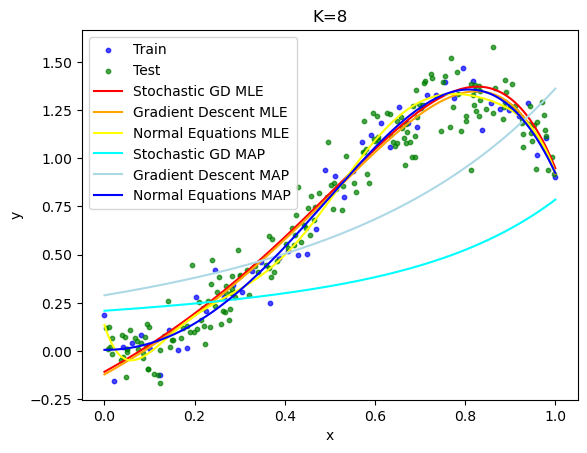

In [32]:
K=8

plt.scatter(X_train, Y_train, s=10, c='blue', alpha=0.7, label="Train")
plt.scatter(X_test, Y_test, s=10, c='green', alpha=0.7, label="Test")

t1, t2, t3 = train_model(X_train, Y_train, K, np.ones(K), loss_MLE, grad_loss_MLE)
x=np.linspace(0,1,1000)
y1=phi(x,K).T@t1[-1]
y2=phi(x,K).T@t2[-1]
y3=phi(x,K).T@t3[-1]

plt.plot(x, y1, color="red", label="Stochastic GD MLE")
plt.plot(x, y2, color="orange", label="Gradient Descent MLE")
plt.plot(x, y3, color="yellow", label="Normal Equations MLE")


t1, t2, t3 = train_MAP(X_train, Y_train, K, np.ones(K), loss_MAP, grad_loss_MAP, 0.001)

y4=phi(x,K).T@t1[-1]
y5=phi(x,K).T@t2[-1]
y6=phi(x,K).T@t3[-1]

plt.plot(x, y4, color="cyan", label="Stochastic GD MAP")
plt.plot(x, y5, color="lightblue", label="Gradient Descent MAP")
plt.plot(x, y6, color="blue", label="Normal Equations MAP")

plt.title(f"K={K}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In the experiments using the MAP formulation with a Gaussian prior, we tested the impact of different values of $ \lambda$ while keeping $ K = 8$. The results revealed several important trends regarding the effect of regularization and the optimization methods used.

When comparing the three optimization methods—Stochastic Gradient Descent (SGD), Gradient Descent (GD), and Normal Equations (NE)—it became evident that NE consistently outperformed both SGD and GD across all values of $ \lambda$. While SGD and GD exhibited a noticeable sensitivity to changes in $ \lambda$, with errors fluctuating more significantly as $ \lambda$ increased, NE showed a much more stable and low-error performance. This suggests that the Normal Equations method, which directly solves for the optimal $ \theta$, is less influenced by the choice of regularization and performs better in scenarios with varying regularization strengths.

For smaller values of $ \lambda$ (such as 0.001 and 0.01), the results from SGD, GD, and NE were similar, with errors being relatively low and comparable to the MLE approach. In these cases, the regularization term had minimal influence, and the models could fit the training data with flexibility. However, as $ \lambda$ increased (for example, to 1 and 10), the regularization term became dominant, causing the models to underfit the data. The error increased significantly for SGD and GD, particularly at larger values of $ \lambda$, where the models became overly constrained by the regularization, preventing them from capturing the data's complexity. In contrast, NE remained more resilient to large $ \lambda$, showing smaller increases in error.

Comparing the MAP and MLE approaches, for small values of $ \lambda$, the results of $ \theta_{MAP}$ were very similar to $ \theta_{MLE}$, since the prior term in MAP had little effect when regularization was weak. However, as $ \lambda$ grew larger, the differences became more noticeable. MAP, with its Gaussian prior, provided a form of regularization that helped prevent overfitting, especially when $ \lambda$ was large. In these cases, the MAP model generally showed better performance in terms of avoiding overfitting, but it also came at the cost of higher bias, leading to higher test errors compared to MLE.

Overall, the results highlight the trade-off between regularization strength and model complexity. Small $ \lambda$ values allowed the models to maintain flexibility and low error, while larger $ \lambda$ values prevented overfitting but also led to underfitting, particularly with SGD and GD. NE proved to be the most robust across all scenarios, and the MAP formulation was effective in controlling overfitting when using larger $ \lambda$, though at the expense of some loss in accuracy compared to MLE.